In [25]:
# Zarządzanie bibliotekami - import wszystkich potrzebnych bibliotek do dalszej analizy

import pandas as pd
from pandas import read_csv

import numpy as np

import matplotlib
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib. dates as mandates
from matplotlib import pyplot
import seaborn as sns

import xgboost as xg
import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn. preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from keras. layers import LSTM, Dense, Dropout
from keras. models import Sequential, load_model
import keras. backend as K
from keras. callbacks import EarlyStopping
from keras. utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
# Funkcja importująca zbiór danych i dodająca RoRy

def import_explore(dataset):
        series = read_csv(dataset)#, parse_dates=['date']), index_col='date')

        series['RoR_date'] = (series.groupby('symbol')['adj_close_date'].apply(pd.Series.pct_change) + 1)
        series['RoR_mtd'] = (series.groupby('symbol')['adj_close_mtd'].apply(pd.Series.pct_change) + 1)
        series['RoR_qtd'] = (series.groupby('symbol')['adj_close_qtd'].apply(pd.Series.pct_change) + 1)
        series['RoR_htd'] = (series.groupby('symbol')['adj_close_htd'].apply(pd.Series.pct_change) + 1)
        series['RoR_ytd'] = (series.groupby('symbol')['adj_close_ytd'].apply(pd.Series.pct_change) + 1)

        df = series.dropna()
  
        return(df)

In [3]:
def getX(dataset, X_names):

        X = pd.DataFrame(dataset[X_names])
        scaler = MinMaxScaler(feature_range=(0, 1))
        X = scaler.fit_transform(X)
        return(X)


def getY(dataset, Y_name):

        Y = pd.DataFrame(dataset[Y_name]) 
        scaler = MinMaxScaler(feature_range=(0, 1))
        Y = scaler.fit_transform(Y)
        return(Y)

#X = getX(df, X_col)
#Wybór zmiennej objaśnianej (horyzontu czasowego analizy)
#Y_name = Y_col[1]
#Y = getY(df, Y_name)

In [4]:
# Regresja liniowa wersja 1

def linear_regression_1(X1, X2, y1, y2):
        lineReg = LinearRegression()
        lineReg.fit(X1, y1)
        #print('Score: ', lineReg.score(X2, y2))
        #print('Weights: ', lineReg.coef_)

        Y_pred = lineReg.predict(X2)
        rmse = np.sqrt(mean_squared_error(y2, Y_pred))
        print("RMSE dla regresji liniowej 1: % f" %(rmse))

#linear_regression_1(X_train, X_test, y_train, y_test)

In [5]:
# Regresja liniowa wersja 2

def linear_regression_2(X1, X2, y1, y2):
        regr = linear_model.LinearRegression()
        regr.fit(X1,y1)
        Y_pred = regr.predict(X2)
        rmse = np.sqrt(mean_squared_error(y2, Y_pred))
        print("RMSE dla regresji liniowej 2: % f" %(rmse))

#linear_regression_2(X_train, X_test, y_train, y_test)

Realizacja regresji liniowej nr 3.

In [84]:
# Regresja liniowa wersja 3

def linear_regression_3(X1, X2, y1, y2):
          model = linear_model.LinearRegression()
          X_train = pd.DataFrame(X1)
          y_train = pd.DataFrame(y1)

          model.fit(X_train, y_train)

          Y_pred_train = model.predict(X_train)
          
          rmse = np.sqrt(mean_squared_error(y_train, Y_pred_train))
          print("RMSE dla regresji 3 (zbiór uczący się): % f" %(rmse))
          
          X_test = pd.DataFrame(X2)
          Y_pred_test = model.predict(X_test)
          rmse = np.sqrt(mean_squared_error(y2, Y_pred_test))
          print("RMSE dla regresji 3 (zbiór testowy): % f" %(rmse))
          print("Wyniki walidacji krzyżowej dla regresji liniowej:")
          linear_scores = cross_validate(model, X, Y, scoring="neg_root_mean_squared_error")
          print(linear_scores)
          for k, v in linear_scores.items():
              print(k, v.mean())
          chart = pd.DataFrame({'y2':y2.flatten(), 'pred':Y_pred_test.flatten()})
          chart = chart.reset_index()
          plt.figure(figsize=(10,10))
          plt.scatter(chart['y2'], chart["pred"], c='crimson')
          p1 = max(max(chart['y2']), max(chart["pred"]))
          p2 = min(min(chart['y2']), min(chart["pred"]))
          plt.plot([p1, p2], [p1, p2], 'b-')
          plt.xlabel('True Values', fontsize=15)
          plt.ylabel('Predictions', fontsize=15)
          plt.axis('equal')
          plt.show()
          plt.tight_layout()
          plt.savefig('chart1.png')
          plt.show()

#linear_regression_3(X_train, X_test, y_train, y_test)

In [85]:
# Model XGBoosting

def XGBmodel(X1, X2, y1, y2):

          train_dmatrix = xg.DMatrix(data = X1, label = y1)
          test_dmatrix = xg.DMatrix(data = X2, label = y2)

          param = {"booster":"gblinear", "objective":"reg:linear"}
            
          xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
          pred = xgb_r.predict(test_dmatrix)
            
          rmse = np.sqrt(mean_squared_error(y2, pred))
          print("")
          print("RMSE dla XGBoosting: % f" %(rmse))
          print("Wyniki walidacji krzyżowej dla XGBoost:")
          data_dmatrix = xg.DMatrix(data=X_train, label=y_train)
          xgb_cv = xg.cv(dtrain=data_dmatrix, params=param, nfold=5, metrics = 'rmse',seed=42) 
          print(xgb_cv["train-rmse-mean"].mean())
          print("")
          chart = pd.DataFrame({'y2':y2.flatten(), 'pred':pred.flatten()})
          chart = chart.reset_index()
          plt.figure(figsize=(10,10))
          plt.scatter(chart['y2'], chart["pred"], c='crimson')
          p1 = max(max(chart['y2']), max(chart["pred"]))
          p2 = min(min(chart['y2']), min(chart["pred"]))
          plt.plot([p1, p2], [p1, p2], 'b-')
          plt.xlabel('True Values', fontsize=15)
          plt.ylabel('Predictions', fontsize=15)
          plt.axis('equal')
          plt.show()
          plt.tight_layout()
          plt.savefig('chart2.png')
          plt.show()

#XGBmodel(X_train, X_test, y_train, y_test)

In [86]:
# Model LSTM

def LSTMmodel(X1, X2, y1, y2):

      model = Sequential()
      model.add(LSTM(units=50,return_sequences=True,input_shape=(X1.shape[1], 1)))
      model.add(Dropout(0.2))
      model.add(LSTM(units=50,return_sequences=True))
      model.add(Dropout(0.2))
      model.add(LSTM(units=50,return_sequences=True))
      model.add(Dropout(0.2))
      model.add(LSTM(units=50))
      model.add(Dropout(0.2))
      model.add(Dense(units=1))
      model.compile(optimizer='adam',loss='mean_squared_error')
      model.fit(X1,y1,epochs=10,batch_size=32) # Przy testach 100 zmienić na 1
      pred = model.predict(X2)
      rmse = np.sqrt(mean_squared_error(y2, pred))
      print("")
      print("RMSE dla LSTM: % f" %(rmse))
      chart = pd.DataFrame({'y2':y2.flatten(), 'pred':pred.flatten()})
      chart = chart.reset_index()
      plt.figure(figsize=(10,10))
      plt.scatter(chart['y2'], chart["pred"], c='crimson')
      p1 = max(max(chart['y2']), max(chart["pred"]))
      p2 = min(min(chart['y2']), min(chart["pred"]))
      plt.plot([p1, p2], [p1, p2], 'b-')
      plt.xlabel('True Values', fontsize=15)
      plt.ylabel('Predictions', fontsize=15)
      plt.axis('equal')
      plt.show()
      plt.tight_layout()
      plt.savefig('chart3.png')
      plt.show()
# LSTMmodel(X_train, X_test, y_train, y_test)


In [87]:
# Model LightGBM

def LGBMmodel(X1, X2, y1, y2):
      lgbm = lgb.LGBMRegressor()

      lgbm.fit(X1, y1)
      pred = lgbm.predict(X2)

      rmse = np.sqrt(mean_squared_error(y2, pred))
      print("RMSE dla LGBM: % f" %(rmse))
      print("")
      print("Wyniki walidacji krzyżowej dla LightGBM:")
      lgbm_scores = cross_validate(lgbm, X, Y, scoring="neg_root_mean_squared_error")
      print(lgbm_scores)
      for k, v in lgbm_scores.items():
          print(k, v.mean())
      chart = pd.DataFrame({'y2':y2.flatten(), 'pred':pred.flatten()})
      chart = chart.reset_index()
      plt.figure(figsize=(10,10))
      plt.scatter(chart['y2'], chart["pred"], c='crimson')
      p1 = max(max(chart['y2']), max(chart["pred"]))
      p2 = min(min(chart['y2']), min(chart["pred"]))
      plt.plot([p1, p2], [p1, p2], 'b-')
      plt.xlabel('True Values', fontsize=15)
      plt.ylabel('Predictions', fontsize=15)
      plt.axis('equal')
      plt.show()
      plt.tight_layout()
      plt.savefig('chart4.png')
      plt.show()
#LGBMmodel(X_train, X_test, y_train, y_test)

Wprowadź interesujący cię zakres: RoR_date, RoR_mtd, RoR_qtd, RoR_htd, RoR_ytd RoR_mtd
RMSE dla regresji 3 (zbiór uczący się):  0.000001
RMSE dla regresji 3 (zbiór testowy):  87.019903
Wyniki walidacji krzyżowej dla regresji liniowej:
{'fit_time': array([0.04135132, 0.0426476 , 0.04203725, 0.04492593, 0.05004525]), 'score_time': array([0.00114059, 0.00183725, 0.00110006, 0.00350165, 0.00353146]), 'test_score': array([-1.40271801e-02, -9.98799017e+01, -4.34086388e-04, -2.56074704e-04,
       -5.41494932e-04])}
fit_time 0.04420146942138672
score_time 0.0022222042083740235
test_score -19.97903209969943


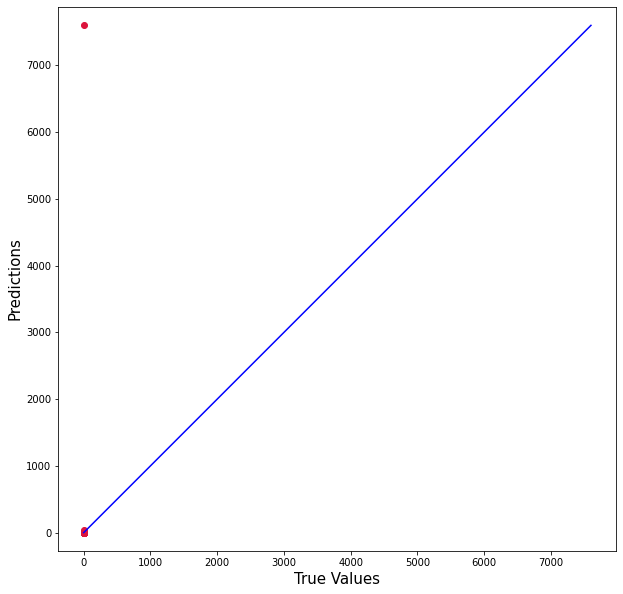

<Figure size 432x288 with 0 Axes>

[16:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

RMSE dla XGBoosting:  0.002564
Wyniki walidacji krzyżowej dla XGBoost:
[16:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.00839238



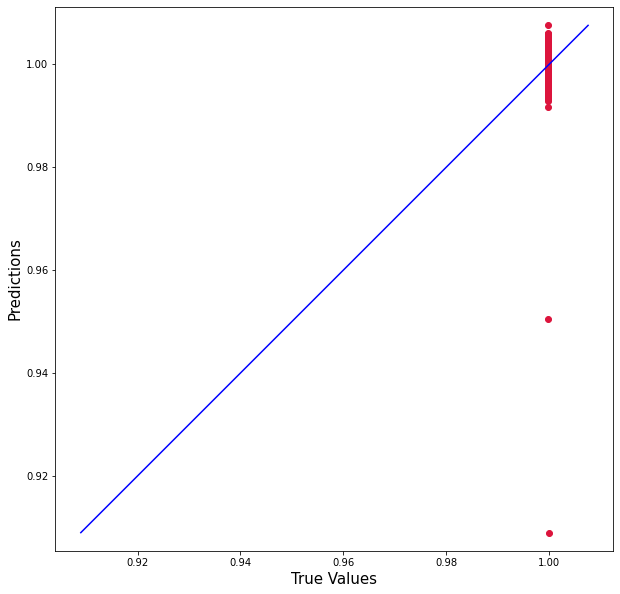

<Figure size 432x288 with 0 Axes>

Epoch 1/10
556/556 [==============================] - 41s 60ms/step - loss: 0.0201
Epoch 2/10
556/556 [==============================] - 35s 63ms/step - loss: 0.0050
Epoch 3/10
556/556 [==============================] - 33s 60ms/step - loss: 0.0044
Epoch 4/10
556/556 [==============================] - 34s 61ms/step - loss: 0.0038
Epoch 5/10
556/556 [==============================] - 35s 63ms/step - loss: 0.0032
Epoch 6/10
556/556 [==============================] - 33s 60ms/step - loss: 0.0027
Epoch 7/10
556/556 [==============================] - 33s 60ms/step - loss: 0.0021
Epoch 8/10
556/556 [==============================] - 34s 61ms/step - loss: 0.0015
Epoch 9/10
556/556 [==============================] - 33s 60ms/step - loss: 0.0011
Epoch 10/10
556/556 [==============================] - 33s 59ms/step - loss: 7.2299e-04

RMSE dla LSTM:  0.004168


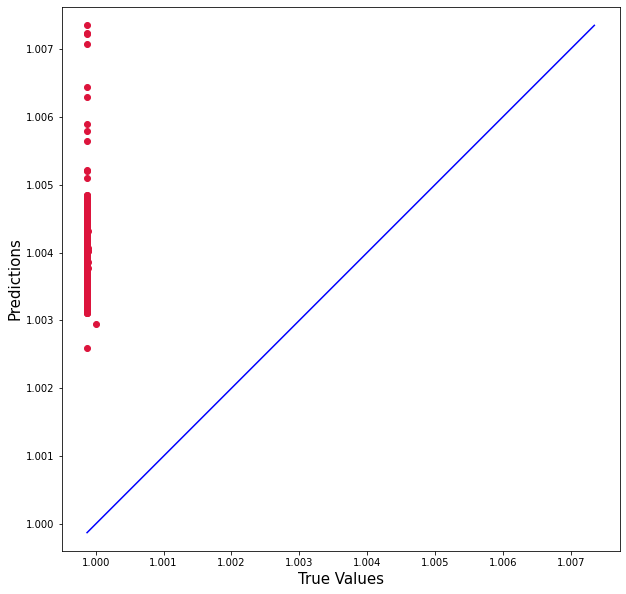

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE dla LGBM:  0.001028

Wyniki walidacji krzyżowej dla LightGBM:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

{'fit_time': array([0.56765103, 0.48117685, 0.53155589, 0.50790095, 0.54018021]), 'score_time': array([0.01823354, 0.02011752, 0.02275515, 0.02199292, 0.0231986 ]), 'test_score': array([-0.01402722, -0.00498317, -0.00299483, -0.00082425, -0.00086006])}
fit_time 0.5256929874420166
score_time 0.021259546279907227
test_score -0.004737906678927399


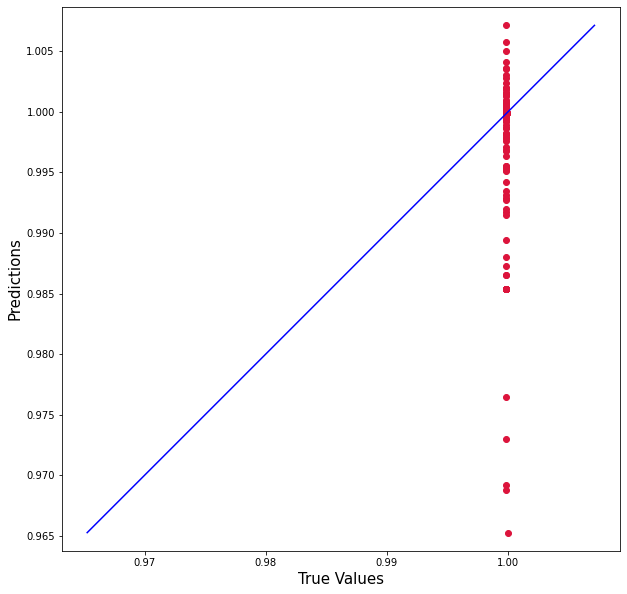

<Figure size 432x288 with 0 Axes>

In [88]:
# KOD - Komórka do uzyskania wyników (wcześniej zaimportuj biblioteki i wywołaj funkcje)

#Funkcja 1
data = 'convictions_returns.csv'
df = import_explore(data)

# Porządkowanie kolumn w zbiorze danych

# Wektor nazw zmiennych objaśnianych Y
Y_col = ['RoR_date','RoR_mtd','RoR_qtd','RoR_htd','RoR_ytd']
# Wektor nazw kolumn do usunięcia
Others = ['Unnamed: 0','symbol','sector','date']
all_column = df.columns
X_col = np.setdiff1d(all_column, Y_col)
# Wektor nazw zmeinnych objaśniających X
X_col = np.setdiff1d(X_col, Others)

# Funkcja 2 i 3
X = getX(df, X_col)
#Wybór zmiennej objaśnianej (horyzontu czasowego analizy)
check_list = ['RoR_date', 'RoR_mtd', 'RoR_qtd', 'RoR_htd', 'RoR_ytd']
Y_name = input("Wprowadź interesujący cię zakres: RoR_date, RoR_mtd, RoR_qtd, RoR_htd, RoR_ytd ")
while Y_name not in check_list:
    Y_name = input("Wprowadź poprawny zakres: RoR_date, RoR_mtd, RoR_qtd, RoR_htd, RoR_ytd ")
    if Y_name in check_list:
        break
Y = getY(df, Y_name)

# Podział zbioru na uczący się i testowy
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 23, shuffle = True)

# Funkcja 4 
linear_regression_3(X_train, X_test, y_train, y_test)
# Funkcja 5
XGBmodel(X_train, X_test, y_train, y_test)
# Funkcja 6
LSTMmodel(X_train, X_test, y_train, y_test)
# Funkcja 7
LGBMmodel(X_train, X_test, y_train, y_test)